### ML Modeling for Housing Price Prediction

#### Author: Vivek Pandey

Note: The data engineering and eda notebooks need to be run before running this, since it expects certain outputs generated by those notebooks

In [236]:
# Dependency imports
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Notebook customizations
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1
import warnings
warnings.filterwarnings('ignore')

In [237]:
def heatMap(df, mirror):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(15, 6))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

In [238]:
transactions_master_df = pd.read_csv('./output/post_eda_transactions_master.csv', sep='|', \
                                     dtype={'zip_code': str}, encoding='latin1')
transactions_master_df.head()

,document_type,price,property_url,transaction_type,recording_year,recording_month,recording_day,contract_year,contract_month,contract_day,address,area_sqft,built_year,city,lot_size,no_of_baths,no_of_bedrooms,property_type,state,tax_amount,tax_year,zip_code
0,Deed,224000.0,https://www.trulia.com/p/ny/holmes/10-cliff-ct-holmes-ny-12531--2305202587,Purchase/Resale Arm's Length Residential Transaction,2001,7,30,2001,6,25,10 Cliff Ct,1184.0,1997,Holmes,60984.0,2.5,3.0,Single-Family Home,NY,8320.40,2017,12531
1,Deed,417500.0,https://www.trulia.com/p/ny/craryville/311-taghkanic-churchtown-rd-craryville-ny-12521--2158455139,Purchase/Resale Arm's Length Residential Transaction,2005,7,25,2005,7,22,311 Taghkanic Churchtown Rd,1872.0,1990,Craryville,198198.0,1.0,4.0,Single-Family Home,NY,7563.77,2017,12521
2,Deed,32000.0,https://www.trulia.com/p/ny/craryville/12-taghkanic-churchtown-rd-craryville-ny-12521--2158455187,Insured Non-Residential Grant Deed,1996,10,18,1996,9,10,12 Taghkanic Churchtown Rd,1708.0,1998,Craryville,274428.0,1.0,2.0,Single-Family Home,NY,5769.40,2017,12521
3,Deed,235000.0,https://www.trulia.com/p/ny/craryville/11-taghkanic-churchtown-rd-craryville-ny-12521--1100838069,Purchase/Resale Arm's Length Residential Transaction,2016,10,25,2016,10,25,11 Taghkanic Churchtown Rd,1728.0,2007,Craryville,249163.2,2.5,3.0,Single-Family Home,NY,5270.54,2017,12521
4,Deed,15300.0,https://www.trulia.com/p/ny/craryville/12-taghkanic-churchtown-rd-craryville-ny-12521--2158455186,Insured Non-Residential Grant Deed,1994,6,3,1994,6,1,12 Taghkanic Churchtown Rd,1952.0,1996,Craryville,222591.6,1.5,3.0,Single-Family Home,NY,6896.60,2017,12521


In [239]:
transactions_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226501 entries, 0 to 226500
Data columns (total 22 columns):
document_type       226501 non-null object
price               226501 non-null float64
property_url        226501 non-null object
transaction_type    226501 non-null object
recording_year      226501 non-null int64
recording_month     226501 non-null int64
recording_day       226501 non-null int64
contract_year       226501 non-null int64
contract_month      226501 non-null int64
contract_day        226501 non-null int64
address             226501 non-null object
area_sqft           226501 non-null float64
built_year          226501 non-null int64
city                226501 non-null object
lot_size            226501 non-null float64
no_of_baths         226501 non-null float64
no_of_bedrooms      226501 non-null float64
property_type       226501 non-null object
state               226501 non-null object
tax_amount          226501 non-null float64
tax_year            226501 non

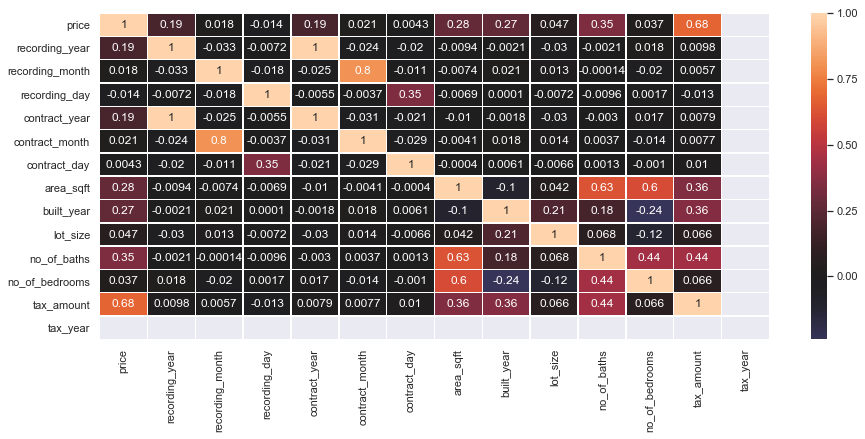

In [240]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(data=transactions_master_df.corr(), linewidths=0.5, center=0, annot=True, ax=ax)

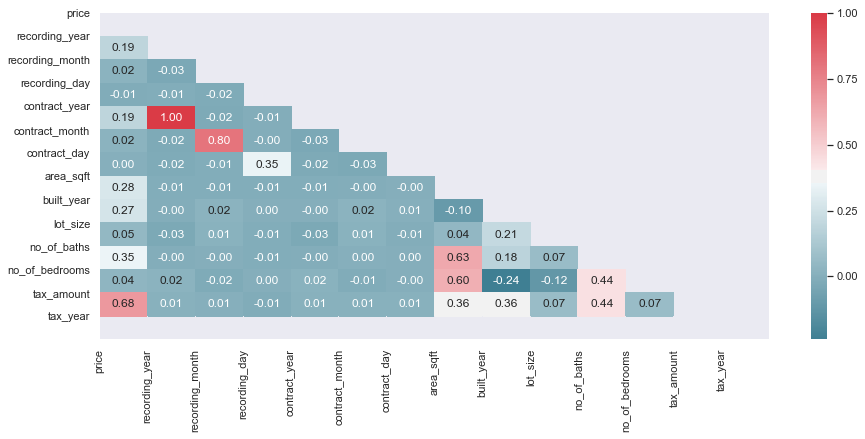

In [241]:
heatMap(transactions_master_df, False)

#### Dropping highly correlated fields and other useless fields

In [242]:
transactions_master_df = transactions_master_df.drop(columns=['contract_year', 'contract_month', 'tax_year'], axis=1)
transactions_master_df = transactions_master_df.drop(columns=['property_url', 'address', 'state'], axis=1)
transactions_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226501 entries, 0 to 226500
Data columns (total 16 columns):
document_type       226501 non-null object
price               226501 non-null float64
transaction_type    226501 non-null object
recording_year      226501 non-null int64
recording_month     226501 non-null int64
recording_day       226501 non-null int64
contract_day        226501 non-null int64
area_sqft           226501 non-null float64
built_year          226501 non-null int64
city                226501 non-null object
lot_size            226501 non-null float64
no_of_baths         226501 non-null float64
no_of_bedrooms      226501 non-null float64
property_type       226501 non-null object
tax_amount          226501 non-null float64
zip_code            226501 non-null object
dtypes: float64(6), int64(5), object(5)
memory usage: 27.6+ MB


In [243]:
print(transactions_master_df['transaction_type'].nunique())
print(transactions_master_df['property_type'].nunique())
print(transactions_master_df['document_type'].nunique())
print(transactions_master_df['city'].nunique())
print(transactions_master_df['zip_code'].nunique())

5
8
40
467
435


In [244]:
print(transactions_master_df['document_type'].value_counts())
print(transactions_master_df['transaction_type'].value_counts())
print(transactions_master_df['property_type'].value_counts())

Deed                                                                                                                                                                                                                    138223
Warranty Deed                                                                                                                                                                                                           44647 
Bargain and Sale Deed                                                                                                                                                                                                   9526  
REO Resale                                                                                                                                                                                                              8292  
Land Contract                                                                                               

### ML Pipeline

#### Performing one hot encoding, and normalizing the data if necessary

In [245]:
transactions_master_df.columns

Index(['document_type', 'price', 'transaction_type', 'recording_year',
       'recording_month', 'recording_day', 'contract_day', 'area_sqft',
       'built_year', 'city', 'lot_size', 'no_of_baths', 'no_of_bedrooms',
       'property_type', 'tax_amount', 'zip_code'],
      dtype='object')

Defining features and target using the dataframe we have

In [246]:
target = transactions_master_df['price'].values
features = transactions_master_df[['document_type', 'transaction_type', 'recording_year',
       'recording_month', 'recording_day', 'contract_day', 'area_sqft',
       'built_year', 'lot_size', 'no_of_baths', 'no_of_bedrooms',
       'property_type', 'tax_amount']]
# ADD CITY AND ZIP_CODE AS WELL, RIGHT NOW THEY ARE REMOVED
features.head()

,document_type,transaction_type,recording_year,recording_month,recording_day,contract_day,area_sqft,built_year,lot_size,no_of_baths,no_of_bedrooms,property_type,tax_amount
0,Deed,Purchase/Resale Arm's Length Residential Transaction,2001,7,30,25,1184.0,1997,60984.0,2.5,3.0,Single-Family Home,8320.40
1,Deed,Purchase/Resale Arm's Length Residential Transaction,2005,7,25,22,1872.0,1990,198198.0,1.0,4.0,Single-Family Home,7563.77
2,Deed,Insured Non-Residential Grant Deed,1996,10,18,10,1708.0,1998,274428.0,1.0,2.0,Single-Family Home,5769.40
3,Deed,Purchase/Resale Arm's Length Residential Transaction,2016,10,25,25,1728.0,2007,249163.2,2.5,3.0,Single-Family Home,5270.54
4,Deed,Insured Non-Residential Grant Deed,1994,6,3,1,1952.0,1996,222591.6,1.5,3.0,Single-Family Home,6896.60


Splitting the data to train and test data

In [247]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=21)

Below we will create a ML pipeline where a series of steps will be taken in order to train the model. This pipeline will also be used in any subsequent predictions. 

The pipeline performs the following order of operations
* ColumnTransformer takes in the categorical columns and performs one hot encoding on them, using a mask for selecting the column subsets based on the dtypes
* Any standard scalers or imputers, if necessary
* Linear Regression Model for training and predictions

In [248]:
categorical_features = (features.dtypes == 'object')
numerical_features = ~categorical_features

In [249]:
categorical_features

document_type       True 
transaction_type    True 
recording_year      False
recording_month     False
recording_day       False
contract_day        False
area_sqft           False
built_year          False
lot_size            False
no_of_baths         False
no_of_bedrooms      False
property_type       True 
tax_amount          False
dtype: bool

In [250]:
numerical_features

document_type       False
transaction_type    False
recording_year      True 
recording_month     True 
recording_day       True 
contract_day        True 
area_sqft           True 
built_year          True 
lot_size            True 
no_of_baths         True 
no_of_bedrooms      True 
property_type       False
tax_amount          True 
dtype: bool

In [251]:
pipeline = Pipeline([
    # Preprocessor to perform necessary scaling on the data before running regression
    ('preprocess', ColumnTransformer(transformers=
        [
            ('hot_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )),
    # Using linear regression modeling
    ('linear_reg', LinearRegression())
])

In [252]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('hot_encoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
     ...ear_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

### Model Evaluation

In [253]:
# print the intercept
print(pipeline.named_steps['linear_reg'].intercept_)

130820.81841942605


In [254]:
features_post_fit = pipeline.named_steps['preprocess'].get_params()
features_post_fit

{'n_jobs': None,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('hot_encoder',
   OneHotEncoder(categorical_features=None, categories=None,
          dtype=<class 'numpy.float64'>, handle_unknown='ignore',
          n_values=None, sparse=True),
   document_type       True 
   transaction_type    True 
   recording_year      False
   recording_month     False
   recording_day       False
   contract_day        False
   area_sqft           False
   built_year          False
   lot_size            False
   no_of_baths         False
   no_of_bedrooms      False
   property_type       True 
   tax_amount          False
   dtype: bool)],
 'hot_encoder': OneHotEncoder(categorical_features=None, categories=None,
        dtype=<class 'numpy.float64'>, handle_unknown='ignore',
        n_values=None, sparse=True),
 'hot_encoder__categorical_features': None,
 'hot_encoder__categories': None,
 'hot_encoder__dtype': numpy.float64,
 'hot_encode

In [255]:
coefficients = pipeline.named_steps['linear_reg'].coef_
coefficients

array([-2.82456810e+04, -1.16180906e+02, -1.39155689e+02, -2.57675452e+03,
       -5.46457236e+02,  1.66426345e+05,  1.32442068e+03,  4.33779517e+03,
        4.32717195e+04, -8.57438828e+02, -3.67353864e+04,  1.27827045e+03,
       -2.45777893e+04, -1.88763135e+03, -2.25429093e+02,  9.44488765e+00,
       -2.36017612e+02, -7.69779600e+03, -1.86732972e+02, -4.73356233e+03,
       -2.16090922e+04, -1.80069599e+02, -3.74997283e+02,  3.86583319e+01,
       -3.96998280e+04, -5.17572562e+01, -1.43300216e+02, -1.92569534e+04,
       -9.51099089e+02, -3.40972908e+02,  1.29405600e+04, -5.77373332e+04,
       -6.91718193e+02, -1.78440781e+03,  1.07622074e+02,  1.50662373e+03,
       -8.75418040e+02, -7.78640531e+02, -8.39835292e+03, -3.01448806e+04,
        2.52123442e+04, -1.73772410e+04,  1.17709123e+04, -1.98556288e+04,
        6.03793184e+04, -1.36222584e+03,  1.09471362e+04, -9.10351826e+03,
       -6.06262058e+04, -2.70593809e+04, -7.07488496e+02, -2.86212922e+03,
       -4.70860556e+00,  

In [256]:
coeff_df = pd.DataFrame(data=coefficients, index=features_post_fit, columns=['Coefficient'])
coeff_df

ValueError: Shape of passed values is (1, 62), indices imply (1, 12)

### Model Predictions

In [257]:
predictions = pipeline.predict(X_test)

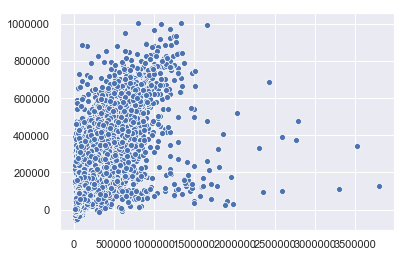

In [259]:
sns.scatterplot(x=y_test, y=predictions)

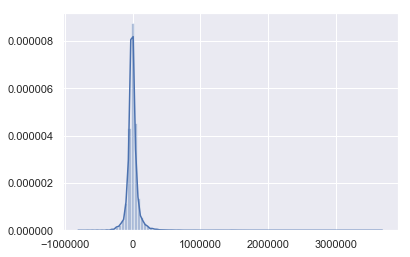

In [260]:
sns.distplot((y_test-predictions), bins=100)

In [261]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

96535.38901828343